# Packages

In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import List, Dict, Tuple
from anndata import AnnData
import scanpy as sc
import time

import pandas as pd
import numpy as np
import math
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import umap

from molmass import Formula
import metaspace
import linex2metaspace as lx2m
import linex2 as lx2
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from statannotations.Annotator import Annotator
import networkx as nx

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.


In [2]:
import utils
from coloc_utils import *
from config import store_dir, data_dir, date_key, enrichment_dir, module_dir
%load_ext autoreload
%autoreload 2

# Analysis

In [41]:
plt.rcParams['figure.figsize'] = (12, 10)

## Positive lipids

In [3]:
tissue_colocs = pickle.load(open(os.path.join(store_dir, 'pos_lip_tissue_colocs.pickle'), "rb" ))
df = pd.concat([x['c_measures'].assign(tissue=tis) for tis, x in tissue_colocs.items()])
df['mean_sig'] = df['pval_mean_corr'] <= 0.05
df['mediqr_sig'] = df['pval_mediqr_corr'] <= 0.05

In [13]:
enrichment_dir

'/g/alexandr/tim/metaspace_evaluation/230201/enrichment'

### Tissue modules

In [31]:
lion_terms = pd.read_csv(os.path.join(enrichment_dir, 'LION_ontology_translator.csv'))

In [32]:
lion_terms

ID                             name
0       CAT:0000000             lipid classification
1       CAT:0000091  physical or chemical properties
2       CAT:0000092                 charge headgroup
3       CAT:0000100              contains fatty acid
4       CAT:0000123                     type by bond
...             ...                              ...
63539  LION:0144646                         RE(26:4)
63540  LION:0144647                         RE(26:5)
63541  LION:0144648                         RE(26:6)
63542  LION:0144649                         RE(26:7)
63543           all                              all

[63544 rows x 2 columns]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


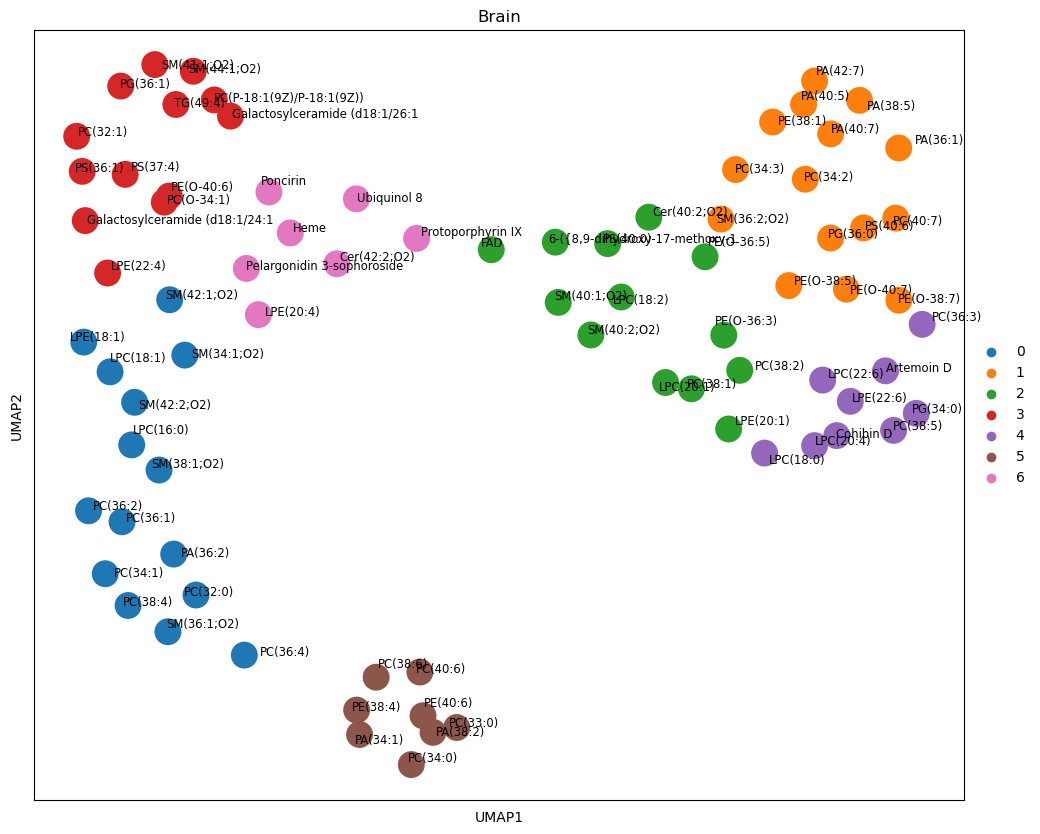

In [42]:
tissue='Brain'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [47]:
tissue_enrichment['0']

n  ES_median     ES_sd  p.value_median  p.value_sd  \
term                                                               
LION:0000466  3  50.265000  0.000000        0.000026    0.000000   
LION:0000599  3  62.831250  0.000000        0.000013    0.000000   
LION:0000095  3   5.810983  0.000000        0.013516    0.000000   
LION:0012080  3   5.794236  0.000000        0.013622    0.000000   
LION:0002969  6   2.532242  0.316861        0.021322    0.029622   
LION:0000003  3   3.662295  0.000000        0.045108    0.000000   
LION:0012009  3   2.956765  0.000000        0.076239    0.000000   
LION:0002957  7   1.679098  0.000000        0.093161    0.000000   
LION:0002922  3   2.706057  0.539957        0.093991    0.038058   
LION:0012010  3   1.936994  0.000000        0.196625    0.000000   

              q.value_median  q.value_sd  fraction.bootstrap.presence  \
term                                                                    
LION:0000466        0.000116    0.000010                         1.00   
LION:0000599        0.000116    0.000010                         1.00   
LION:0000095        0.030649    0.003249                         1.00   
LION:0012080        0.030649    0.003249                         1.00   
LION:0002969        0.038380    0.033577                         1.00   
LION:0000003        0.067663    0.008375                         1.00   
LION:0012009        0.095299    0.005923                         1.00   
LION:0002957        0.103512    0.000909                         0.98   
LION:0002922        0.105739    0.038044                         0.80   
LION:0012010        0.196625    0.000000                         1.00   

                                                      name  
term                                                        
LION:0000466                  positive intrinsic curvature  
LION:0000599                      lysoglycerophospholipids  
LION:0000095  headgroup with positive charge / zwitter-ion  
LION:0012080                    endoplasmic reticulum (ER)  
LION:0002969                    monounsaturated fatty acid  
LION:0000003                     glycerophospholipids [GP]  
LION:0012009                     lipid-mediated signalling  
LION:0002957                    fatty acid with 18 carbons  
LION:0002922                                         C18:1  
LION:0012010                            membrane component

**TODO**

<mark style="background-color: #FFFF00">For Kidney, find good examples to show the different regulation in these clusters.</mark>

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


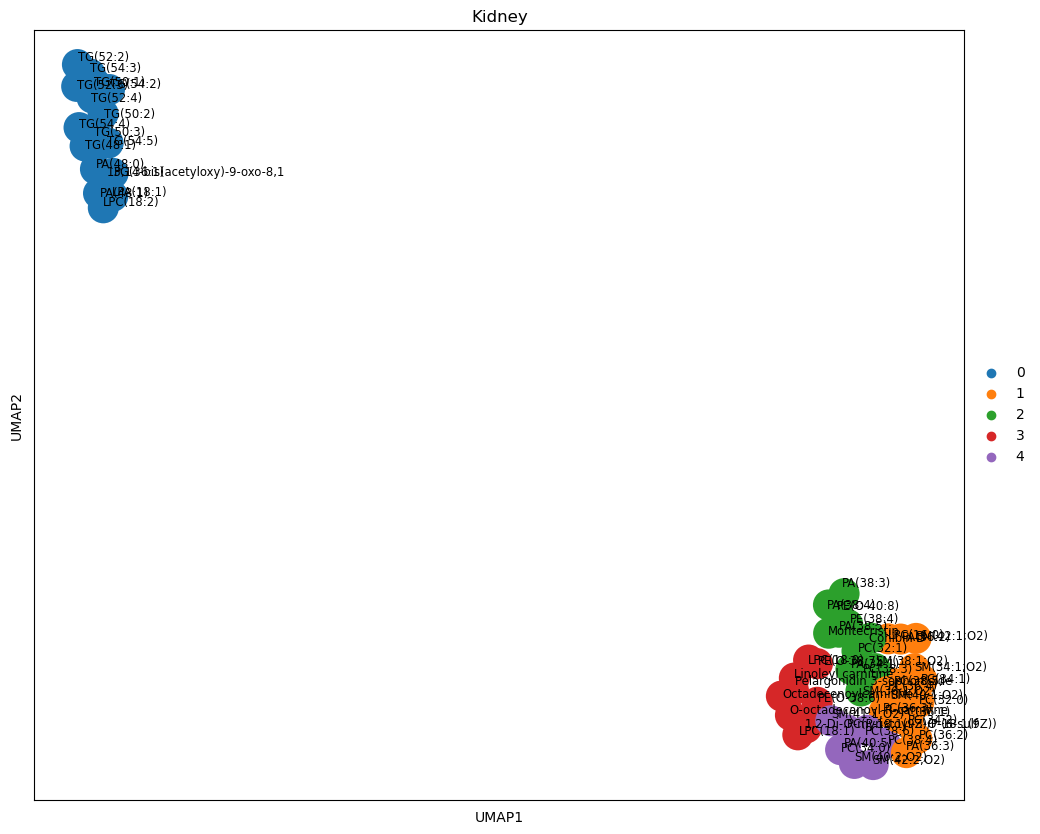

In [66]:
tissue='Kidney'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [72]:
tissue_colocs['Kidney'].keys()

dict_keys(['coloc_dict', 'molecule_names', 'molecule_ids', 'ii_dict', 'c_measures_min_datasets', 'c_measures'])

In [65]:
tissue_colocs['Kidney']['coloc_dict'].keys()

dict_keys(['2022-12-07_02h13m50s', '2022-12-07_02h13m20s', '2022-12-07_02h10m45s', '2022-12-07_02h09m41s', '2022-12-07_02h08m52s', '2022-12-07_01h57m04s', '2022-12-07_01h59m02s', '2022-12-07_01h56m07s', '2022-12-07_01h02m53s', '2022-12-07_01h01m06s', '2022-11-28_22h25m22s', '2022-11-28_22h24m25s', '2022-11-28_22h23m30s', '2022-11-18_18h52m17s', '2022-01-10_19h24m04s', '2022-01-06_23h30m19s', '2022-01-06_23h29m16s', '2021-08-20_21h55m45s', '2021-08-20_21h54m58s', '2021-08-20_21h54m18s', '2021-08-20_21h53m32s', '2021-08-20_21h52m24s', '2021-08-20_21h53m03s', '2021-08-20_21h51m18s', '2021-07-14_18h48m41s', '2021-06-15_23h19m43s', '2021-06-15_22h49m33s', '2021-05-19_20h01m23s', '2021-05-05_23h29m15s', '2021-05-05_23h28m02s', '2021-05-05_23h28m23s', '2021-05-05_23h21m41s', '2021-05-05_23h19m54s', '2021-05-05_23h20m26s', '2021-05-05_21h48m26s', '2021-03-26_18h43m19s', '2021-03-04_23h29m53s', '2021-03-04_23h31m12s', '2021-03-04_23h29m12s', '2021-01-23_21h49m31s', '2020-12-09_02h41m05s', '2020

In [70]:
tissue_adata.obs[tissue_adata.obs['leiden']=='0']

formula                        molecule  \
0    C21H14O10  13,14-bis(acetyloxy)-9-oxo-8,1   
4     C53H98O6                        TG(50:2)   
8    C55H100O6                        TG(52:3)   
10   C57H100O6                        TG(54:5)   
12   C57H102O6                        TG(54:4)   
20   C57H104O6                        TG(54:3)   
21   C53H100O6                        TG(50:1)   
27   C51H99O8P                        PA(48:1)   
35  C42H81O10P                        PG(36:1)   
36  C51H101O8P                        PA(48:0)   
47   C55H102O6                        TG(52:2)   
49   C57H106O6                        TG(54:2)   
52    C53H96O6                        TG(50:3)   
53  C26H50NO7P                       LPC(18:2)   
54    C55H98O6                        TG(52:4)   
58   C21H41O7P                       LPA(18:1)   
59    C51H96O6                        TG(48:1)   

                                             all_hmdb selected_hmdb leiden  
0   [HMDB0128411, HMDB0128410, HMDB0128409, HMDB01...   HMDB0128411      0  
4   [HMDB0062639, HMDB0048479, HMDB0048459, HMDB00...   HMDB0005377      0  
8   [HMDB0050304, HMDB0049861, HMDB0049080, HMDB00...   HMDB0044165      0  
10  [HMDB0054344, HMDB0053355, HMDB0053296, HMDB00...   HMDB0048670      0  
12  [HMDB0053264, HMDB0052441, HMDB0052401, HMDB00...   HMDB0047944      0  
20  [HMDB0051410, HMDB0050433, HMDB0050342, HMDB00...   HMDB0045485      0  
21  [HMDB0046258, HMDB0045532, HMDB0045481, HMDB00...   HMDB0005360      0  
27                         [HMDB0115480, HMDB0115454]   HMDB0115454      0  
35  [HMDB0010632, HMDB0010617, HMDB0010604, HMDB00...   HMDB0010603      0  
36                         [HMDB0115949, HMDB0115453]   HMDB0115453      0  
47  [HMDB0049074, HMDB0049741, HMDB0049702, HMDB00...   HMDB0042196      0  
49  [HMDB0050300, HMDB0049116, HMDB0049076, HMDB00...   HMDB0043954      0  
52  [HMDB0048633, HMDB0048611, HMDB0048590, HMDB00...   HMDB0042167      0  
53                         [HMDB0062711, HMDB0010386]   HMDB0010386      0  
54  [HMDB0052426, HMDB0052398, HMDB0050437, HMDB00...   HMDB0045105      0  
58            [HMDB0011133, HMDB0007855, HMDB0007851]   HMDB0007851      0  
59  [HMDB0045480, HMDB0044053, HMDB0044726, HMDB00...   HMDB0005359      0

In [71]:
tissue_adata.obs[tissue_adata.obs['leiden']=='1']

formula     molecule  \
1     C39H73O8P     PA(36:2)   
2   C47H95N2O6P  SM(42:1;O2)   
13   C44H82NO8P     PC(36:3)   
15  C45H91N2O6P  SM(40:1;O2)   
16   C40H80NO8P     PC(32:0)   
22   C44H86NO8P     PC(36:1)   
28   C24H50NO7P    LPC(16:0)   
38    C39H71O8P     PA(36:3)   
39   C46H82NO8P     PC(38:5)   
41   C44H84NO8P     PC(36:2)   
43   C42H80NO8P     PC(34:2)   
51  C39H79N2O6P  SM(34:1;O2)   
55   C42H82NO8P     PC(34:1)   
56   C44H80NO8P     PC(36:4)   

                                             all_hmdb selected_hmdb leiden  
1   [HMDB0116699, HMDB0115535, HMDB0115510, HMDB01...   HMDB0007864      1  
2                                       [HMDB0012095]   HMDB0012095      1  
13  [HMDB0113077, HMDB0113567, HMDB0113399, HMDB01...   HMDB0008012      1  
15                         [HMDB0012103, HMDB0012092]   HMDB0012092      1  
16  [HMDB0113987, HMDB0113919, HMDB0113087, HMDB01...   HMDB0000564      1  
22  [HMDB0113932, HMDB0114439, HMDB0113728, HMDB01...   HMDB0008037      1  
28                                      [HMDB0010382]   HMDB0010382      1  
38  [HMDB0115564, HMDB0115536, HMDB0115512, HMDB01...   HMDB0114805      1  
39  [HMDB0113651, HMDB0113624, HMDB0113573, HMDB01...   HMDB0008021      1  
41  [HMDB0113933, HMDB0114468, HMDB0113729, HMDB01...   HMDB0000593      1  
43  [HMDB0113925, HMDB0113089, HMDB0114241, HMDB01...   HMDB0008068      1  
51                         [HMDB0061712, HMDB0013464]   HMDB0013464      1  
55  [HMDB0113864, HMDB0114212, HMDB0112991, HMDB01...   HMDB0008035      1  
56  [HMDB0113934, HMDB0114497, HMDB0113055, HMDB01...   HMDB0008013      1

In [ ]:
tissue_enrichment['0']

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


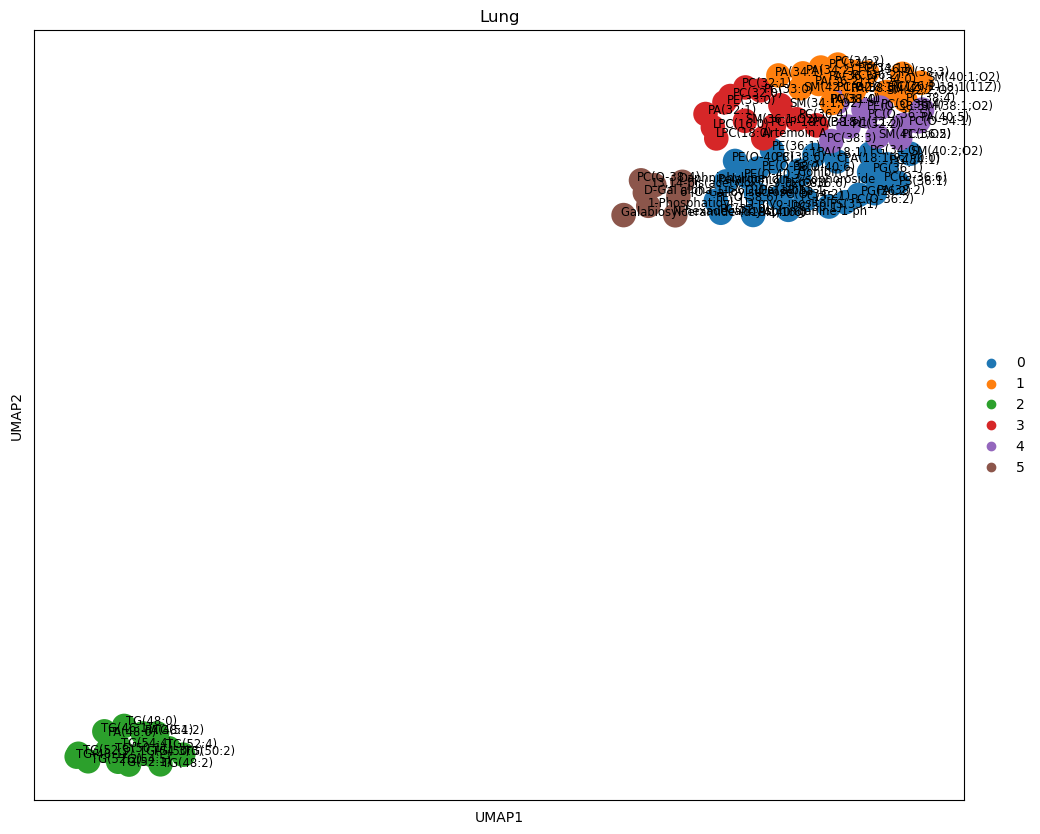

In [52]:
tissue='Lung'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [54]:
tissue_enrichment['2']

n  ES_median     ES_sd  p.value_median  p.value_sd  \
term                                                                
LION:0002927   7   5.717501  1.056616        0.000100    0.004610   
LION:0002970   7   3.804660  0.699333        0.001246    0.017217   
LION:0002967  10   1.938862  0.000000        0.013729    0.000000   
LION:0002959  10   1.727082  0.063959        0.031627    0.008179   
LION:0002953   7   1.985358  0.304766        0.044903    0.047699   
LION:0000259   6   1.967897  0.342864        0.068294    0.060719   
LION:0002971   6   1.881292  0.000000        0.081998    0.000000   
LION:0002969   5   1.861943  0.185168        0.117150    0.038426   
LION:0002955   6   1.744404  0.175045        0.110331    0.035267   
LION:0002928   5   1.884490  0.141538        0.112573    0.028069   
LION:0002882   5   1.717053  0.343411        0.152124    0.058299   
LION:0002957   7   1.481557  0.000000        0.166868    0.000000   
LION:0002947  11   1.268503       NaN        0.187767         NaN   

              q.value_median  q.value_sd  fraction.bootstrap.presence  \
term                                                                    
LION:0002927        0.000701    0.015135                         1.00   
LION:0002970        0.004050    0.022395                         1.00   
LION:0002967        0.027459    0.008451                         1.00   
LION:0002959        0.047440    0.012030                         1.00   
LION:0002953        0.053883    0.049703                         0.98   
LION:0000259        0.081953    0.057299                         0.94   
LION:0002971        0.093712    0.014237                         0.82   
LION:0002969        0.117150    0.044560                         0.84   
LION:0002955        0.119199    0.038651                         0.94   
LION:0002928        0.121248    0.028809                         0.78   
LION:0002882        0.152124    0.056315                         0.74   
LION:0002957        0.175431    0.004944                         0.90   
LION:0002947        0.187767         NaN                         1.00   

                                        name  
term                                          
LION:0002927                           C20:2  
LION:0002970  fatty acid with 2 double bonds  
LION:0002967      polyunsaturated fatty acid  
LION:0002959      fatty acid with 20 carbons  
LION:0002953      fatty acid with 14 carbons  
LION:0000259                           C14:0  
LION:0002971  fatty acid with 3 double bonds  
LION:0002969      monounsaturated fatty acid  
LION:0002955      fatty acid with 16 carbons  
LION:0002928                           C20:3  
LION:0002882                           C16:0  
LION:0002957      fatty acid with 18 carbons  
LION:0002947   fatty acid with 13-15 carbons

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


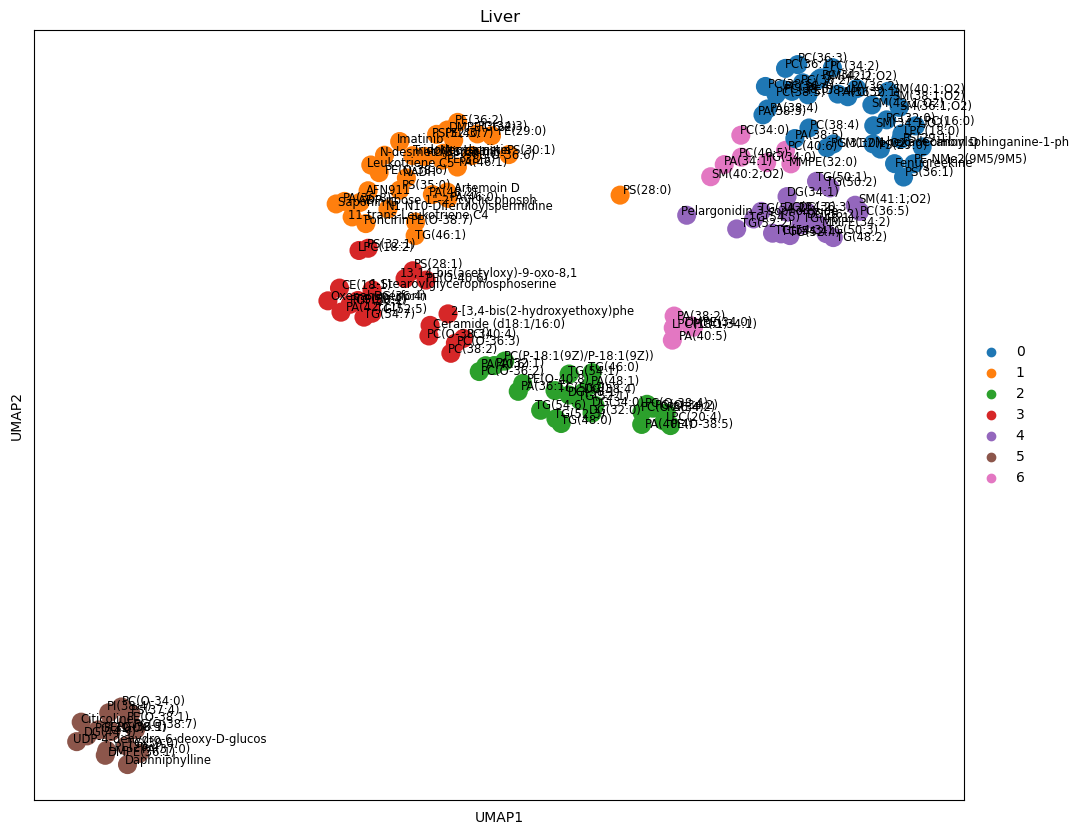

In [55]:
tissue='Liver'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [61]:
tissue_enrichment['5']

n  ES_median     ES_sd  p.value_median  p.value_sd  \
term                                                               
LION:0000003  8   9.155738  0.000000    6.556078e-07    0.000000   
LION:0012010  9   5.447796  0.000000    7.530123e-06    0.000000   
LION:0012080  6  10.864193  0.000000    9.673945e-06    0.000000   
LION:0000095  5   9.079660  0.000000    1.497918e-04    0.000000   
LION:0012081  4  14.611919  0.000000    1.282408e-04    0.000000   
LION:0000011  3  12.650587  0.000000    1.550927e-03    0.000000   
LION:0001734  3   9.424687  0.000000    3.587815e-03    0.000000   
LION:0000093  3   8.849472  0.000000    4.283378e-03    0.000000   
LION:0000464  4   3.213875  0.000000    3.109738e-02    0.000000   
LION:0002972  3   2.759791  0.369737    9.022794e-02    0.028257   
LION:0002961  5   2.037330  0.235251    8.529993e-02    0.034258   
LION:0012009  3   2.771967  0.000000    8.930294e-02    0.000000   
LION:0002922  3   2.536928  0.320540    1.096064e-01    0.031569   
LION:0002882  5   1.824368       NaN    1.239729e-01         NaN   
LION:0002950  5   1.739514  0.155587    1.446882e-01    0.041380   

              q.value_median    q.value_sd  fraction.bootstrap.presence  \
term                                                                      
LION:0000003        0.000007  3.340332e-07                         1.00   
LION:0012010        0.000035  1.642963e-06                         1.00   
LION:0012080        0.000035  1.642963e-06                         1.00   
LION:0000095        0.000330  1.526383e-05                         1.00   
LION:0012081        0.000330  1.526383e-05                         1.00   
LION:0000011        0.002843  1.317000e-04                         1.00   
LION:0001734        0.005638  2.564144e-04                         0.86   
LION:0000093        0.005890  3.799732e-04                         1.00   
LION:0000464        0.038008  2.151919e-03                         1.00   
LION:0002972        0.090228  2.690135e-02                         0.52   
LION:0002961        0.097421  3.468818e-02                         0.54   
LION:0012009        0.098233  4.106115e-03                         1.00   
LION:0002922        0.109606  2.875330e-02                         0.60   
LION:0002882        0.123973           NaN                         0.54   
LION:0002950        0.144688  3.713918e-02                         0.70   

                                                      name  
term                                                        
LION:0000003                     glycerophospholipids [GP]  
LION:0012010                            membrane component  
LION:0012080                    endoplasmic reticulum (ER)  
LION:0000095  headgroup with positive charge / zwitter-ion  
LION:0012081                                 mitochondrion  
LION:0000011            glycerophosphoethanolamines [GP02]  
LION:0001734       contains vinyl ether bond (plasmalogen)  
LION:0000093                headgroup with negative charge  
LION:0000464                  negative intrinsic curvature  
LION:0002972                fatty acid with 4 double bonds  
LION:0002961                    fatty acid with 22 carbons  
LION:0012009                     lipid-mediated signalling  
LION:0002922                                         C18:1  
LION:0002882                                         C16:0  
LION:0002950                 fatty acid with 22-24 carbons

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


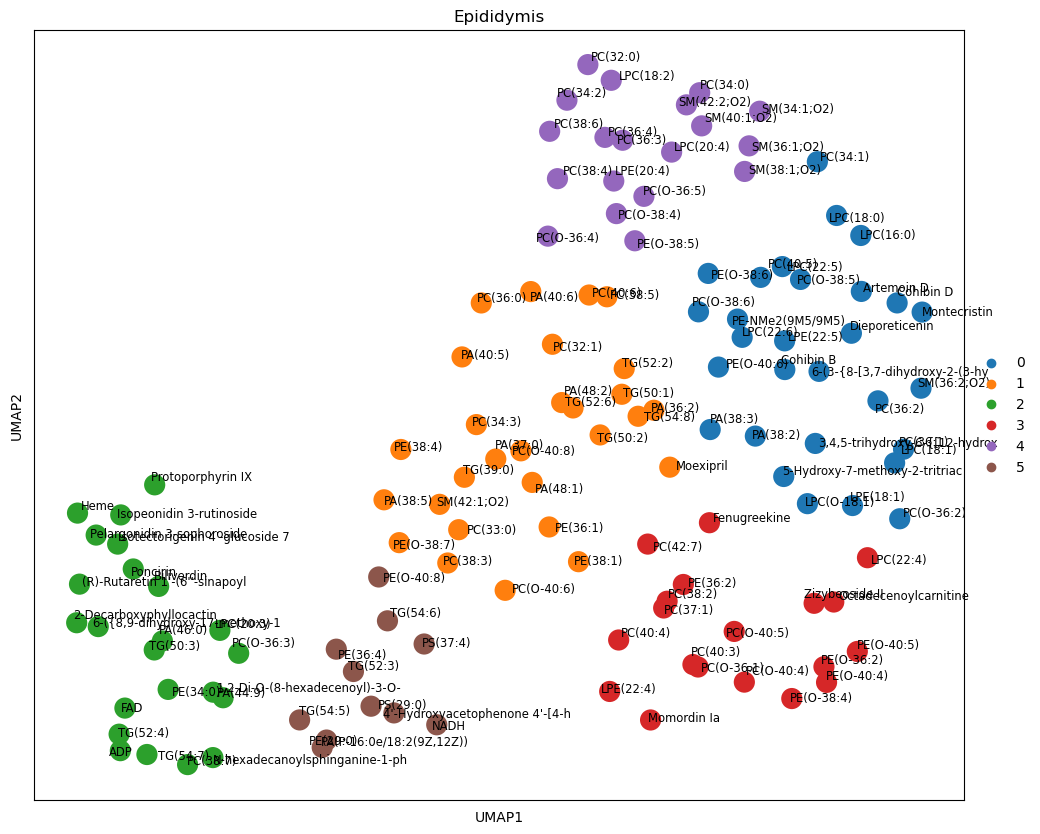

In [73]:
tissue='Epididymis'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [74]:
tissue_enrichment['5']

n  ES_median     ES_sd  p.value_median  p.value_sd  \
term                                                               
LION:0002969  4   2.302038  0.291421        0.081238    0.031202   
LION:0002970  3   2.519970  0.403518        0.107768    0.040173   
LION:0002967  6   1.797854  0.000000        0.082013    0.000000   
LION:0002976  5   1.730888  0.000000        0.135768    0.000000   
LION:0002957  5   1.635485  0.108631        0.164274    0.036056   
LION:0002971  4   1.938301  0.000000        0.134672    0.000000   
LION:0002955  4   1.797265  0.142086        0.166222    0.035931   

              q.value_median  q.value_sd  fraction.bootstrap.presence  \
term                                                                    
LION:0002969        0.082013    0.041271                         0.60   
LION:0002970        0.107768    0.043062                         0.54   
LION:0002967        0.135768    0.026770                         1.00   
LION:0002976        0.135768    0.015118                         0.98   
LION:0002957        0.164274    0.007258                         0.96   
LION:0002971        0.164274    0.015409                         0.66   
LION:0002955        0.166222    0.020146                         0.70   

                                                  name  
term                                                    
LION:0002969                monounsaturated fatty acid  
LION:0002970            fatty acid with 2 double bonds  
LION:0002967                polyunsaturated fatty acid  
LION:0002976  fatty acid with more than 3 double bonds  
LION:0002957                fatty acid with 18 carbons  
LION:0002971            fatty acid with 3 double bonds  
LION:0002955                fatty acid with 16 carbons

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


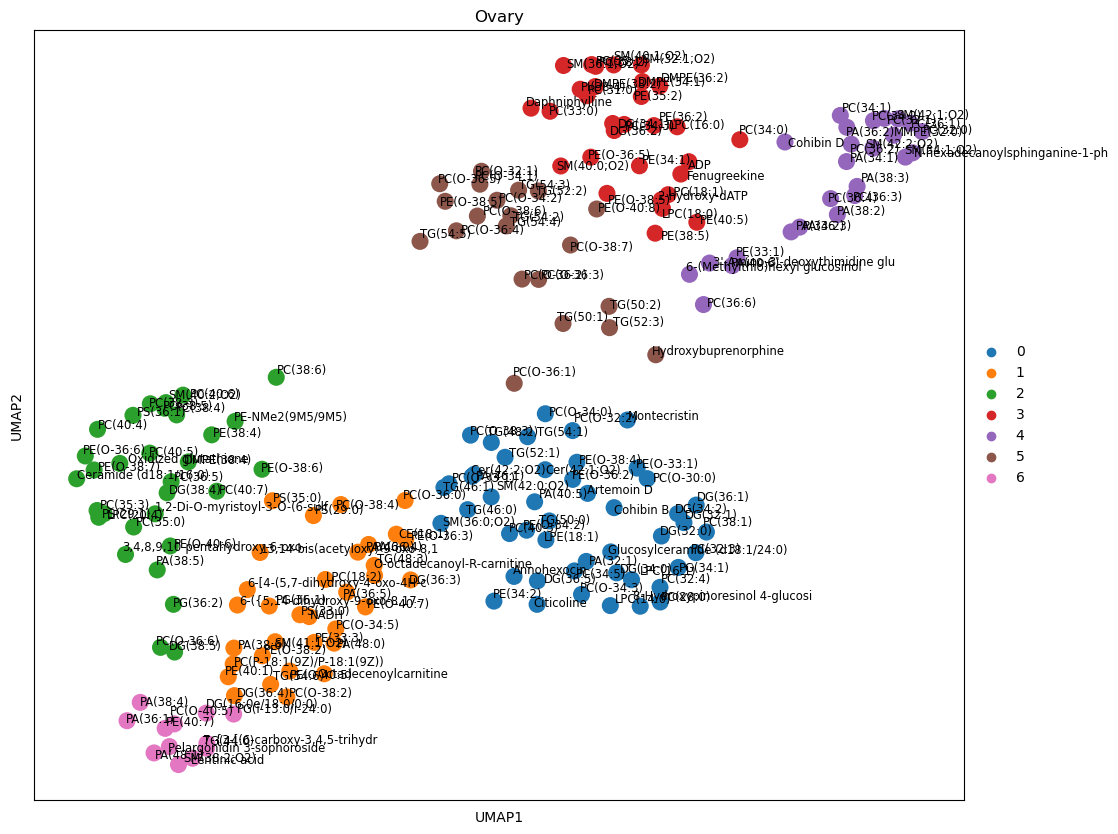

In [75]:
tissue='Ovary'
enr_file = f'enrichment_result_pos_lip_{tissue}'
tissue_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))
tissue_enrichment = {}

for file in [x for x in os.listdir(enrichment_dir) if x.startswith(enr_file)]:
    # My mistake with wrong delimiter..set_index('term').join(lion_terms.set_index('ID'), how='left') Will be fixed in next execution of enrichment analysis
    tissue_enrichment[file.split(enr_file)[1].split('.')[0]] = pd.read_csv(os.path.join(enrichment_dir, 
                                                                                        file), sep=';', decimal=',').set_index('term').join(lion_terms.set_index('ID'), how='left')
    
ax = sc.pl.umap(tissue_adata, color='leiden', show=False)
    
for line in range(0,tissue_adata.shape[0]):
    ax.text(tissue_adata.obsm['X_umap'][line, 0]+np.random.normal(0, 0.05), 
            tissue_adata.obsm['X_umap'][line, 1]+np.random.normal(0, 0.05), 
            tissue_adata.var['molecule'].values[line], 
            horizontalalignment='left', size='small', color='black')
ax.set_title(tissue)
plt.show()

In [76]:
tissue_enrichment['5']

n  ES_median     ES_sd  p.value_median    p.value_sd  \
term                                                                    
LION:0000010  11.0  28.159664  0.840337    2.061964e-14  3.713078e-13   
LION:0000465  11.0  28.009878  0.835868    2.188079e-14  3.917305e-13   
LION:0000095  12.0  16.602808  0.000000    5.091415e-13  0.000000e+00   
LION:0012080  12.0  16.554961  0.000000    5.269299e-13  0.000000e+00   
LION:0001734  10.0  23.935714  3.427926    2.262339e-12  4.811208e-07   
LION:0000032   8.0  33.891277  6.105639    3.574745e-11  5.723376e-07   
LION:0000003  12.0  10.463700  0.000000    1.169861e-10  0.000000e+00   
LION:0012010  12.0   5.534269  0.000000    1.674403e-07  0.000000e+00   
LION:0002922   8.0   5.154393  1.198395    7.330098e-05  5.598325e-03   
LION:0002969  10.0   3.014574  0.587364    6.192077e-04  2.073790e-02   
LION:0002967  13.0   2.040422  0.110939    2.698991e-03  2.176738e-03   
LION:0002957  12.5   2.141707  0.270885    2.763471e-03  2.019781e-02   
LION:0002927   5.0   3.306038  0.702302    1.475820e-02  4.573272e-02   
LION:0002955   9.0   2.118205  0.386505    1.543225e-02  4.034925e-02   
LION:0002948  17.0   1.439615  0.088635    1.659069e-02  2.912828e-02   
LION:0002882   8.0   2.223992  0.421371    1.812953e-02  4.963588e-02   
LION:0002970   6.0   2.639968  0.557205    2.062978e-02  5.469698e-02   
LION:0002921   6.0   2.082876  0.382318    5.761077e-02  5.816403e-02   
LION:0002959  11.0   1.537926  0.148957    6.425471e-02  5.080526e-02   
LION:0002971   7.0   1.776776  0.126913    8.210355e-02  5.241974e-02   
LION:0002928   6.0   1.830647       NaN    9.625364e-02           NaN   
LION:0002977   8.0   1.503618  0.085005    1.377444e-01  3.499896e-02   
LION:0002953   7.0   1.607194  0.000000    1.260186e-01  0.000000e+00   
LION:0002976   8.0   1.450649  0.126594    1.614216e-01  5.177601e-02   
LION:0000259   6.0   1.593059  0.000000    1.602163e-01  0.000000e+00   
LION:0002949  14.0   1.233800       NaN    1.730130e-01           NaN   

              q.value_median    q.value_sd  fraction.bootstrap.presence  \
term                                                                      
LION:0000010    2.078675e-13  1.809057e-12                         1.00   
LION:0000465    2.078675e-13  1.809057e-12                         1.00   
LION:0000095    2.371185e-12  9.584940e-13                         1.00   
LION:0012080    2.371185e-12  9.584940e-13                         1.00   
LION:0001734    9.049357e-12  1.272004e-06                         1.00   
LION:0000032    1.173708e-10  1.323871e-06                         1.00   
LION:0000003    3.342461e-10  5.576408e-11                         1.00   
LION:0012010    3.976707e-07  3.973018e-08                         1.00   
LION:0002922    1.710356e-04  8.578374e-03                         1.00   
LION:0002969    1.050777e-03  2.312368e-02                         1.00   
LION:0002967    3.487926e-03  3.601579e-03                         1.00   
LION:0002957    3.718143e-03  2.297399e-02                         1.00   
LION:0002927    1.961256e-02  4.669348e-02                         1.00   
LION:0002955    1.984147e-02  4.402298e-02                         1.00   
LION:0002948    2.087662e-02  3.298575e-02                         1.00   
LION:0002882    2.595975e-02  5.159319e-02                         1.00   
LION:0002970    2.613105e-02  5.514963e-02                         1.00   
LION:0002921    6.481211e-02  5.955049e-02                         0.96   
LION:0002959    7.139412e-02  5.133410e-02                         1.00   
LION:0002971    9.632410e-02  4.774893e-02                         0.90   
LION:0002928    1.132396e-01           NaN                         0.74   
LION:0002977    1.377444e-01  3.046230e-02                         1.00   
LION:0002953    1.449214e-01  8.567929e-03                         0.84   
LION:0002976    1.614216e-01  4.679972e-02                         1.00   
LION:0000259    1.6446

### Pairplots

To investigate the correlation of colocs between datasets.

The idea would be to check if they are certain clusters of lipids which are highly colocalizaed in one tissue and less colocalized in the other tissue. (The basis for this could also be the Lipid class connection plots).

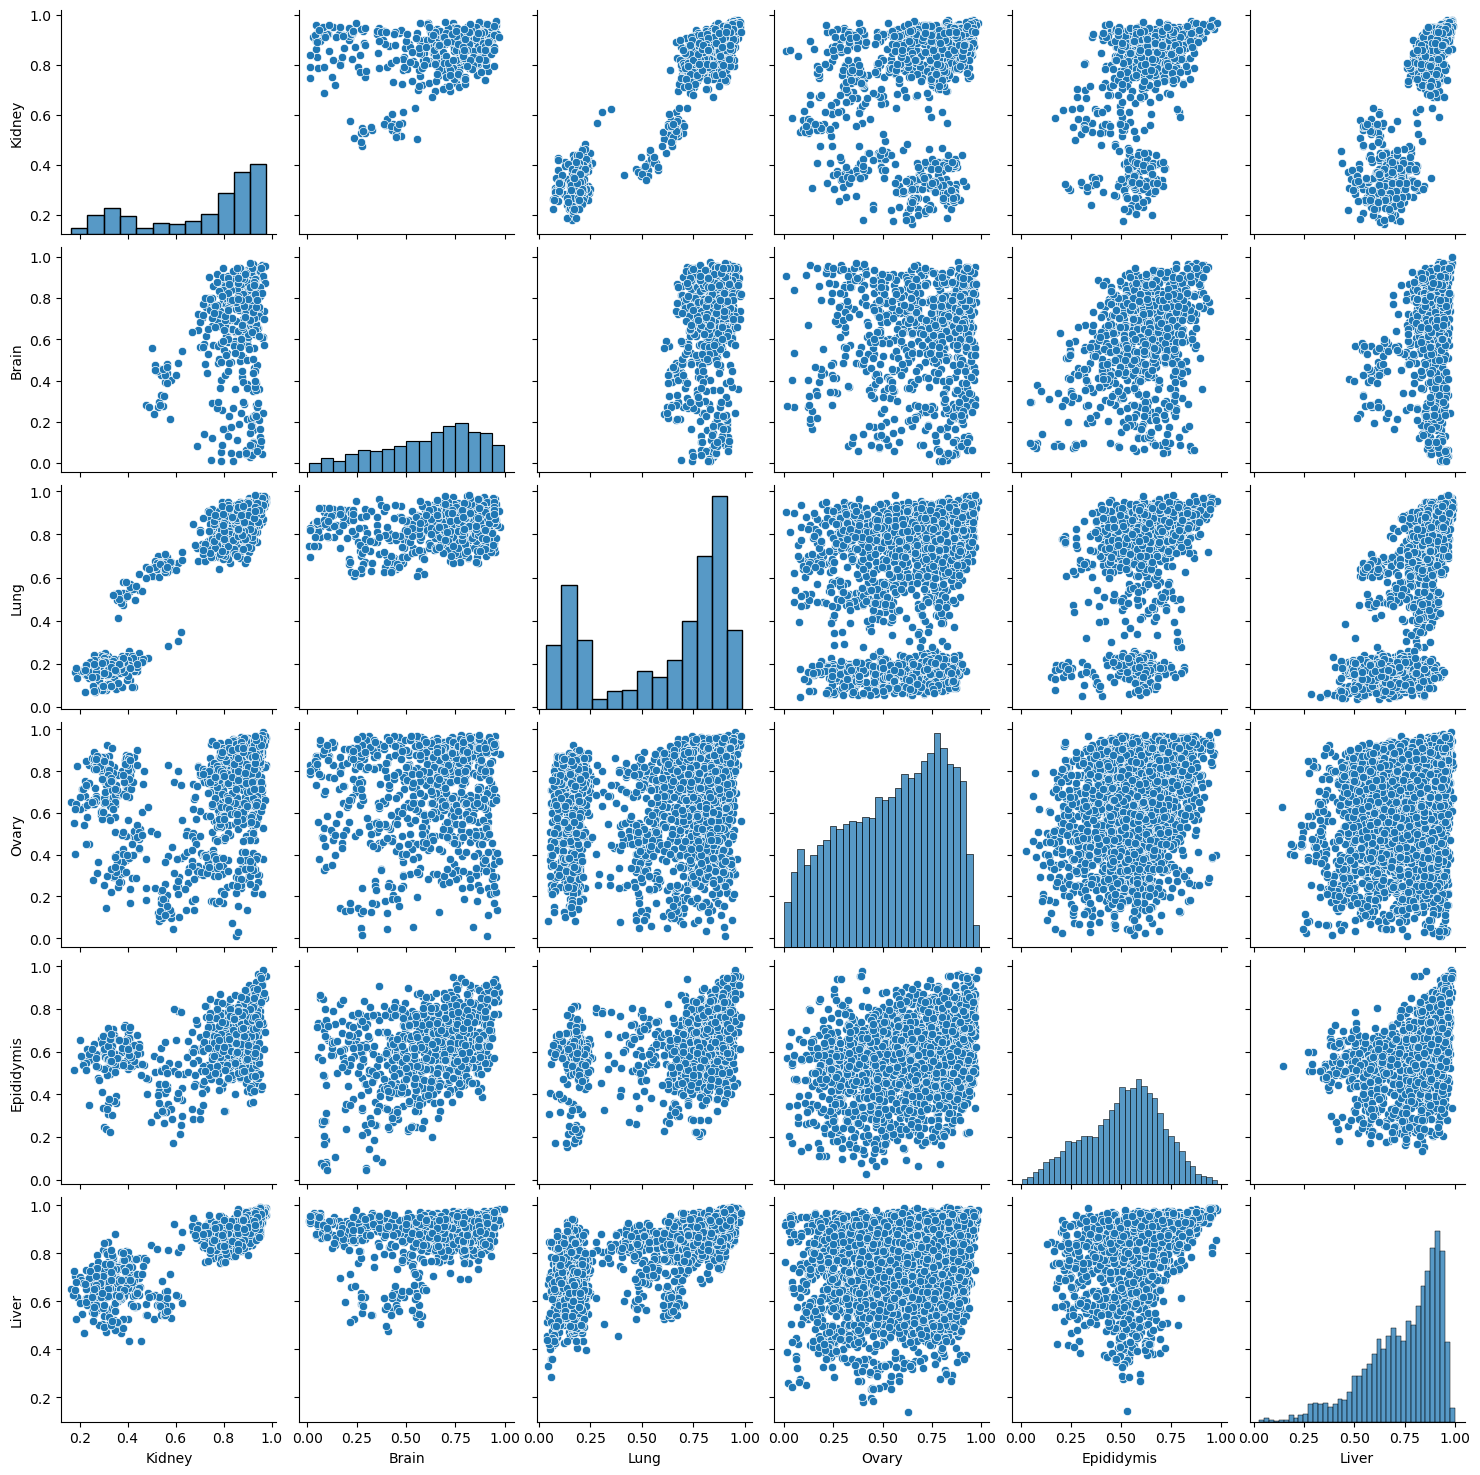

In [88]:
out_dict = {}
for tis in tissue_colocs.keys():
    tmp = df[df['tissue']==tis]['mean']
    curr_series = pd.Series(np.nan, index=list(set(df.index)))
    for key, val in tmp.items():
        curr_series[key]=val
    out_dict[tis] = curr_series
pairdf = pd.DataFrame(out_dict)
    
sns.pairplot(pairdf)

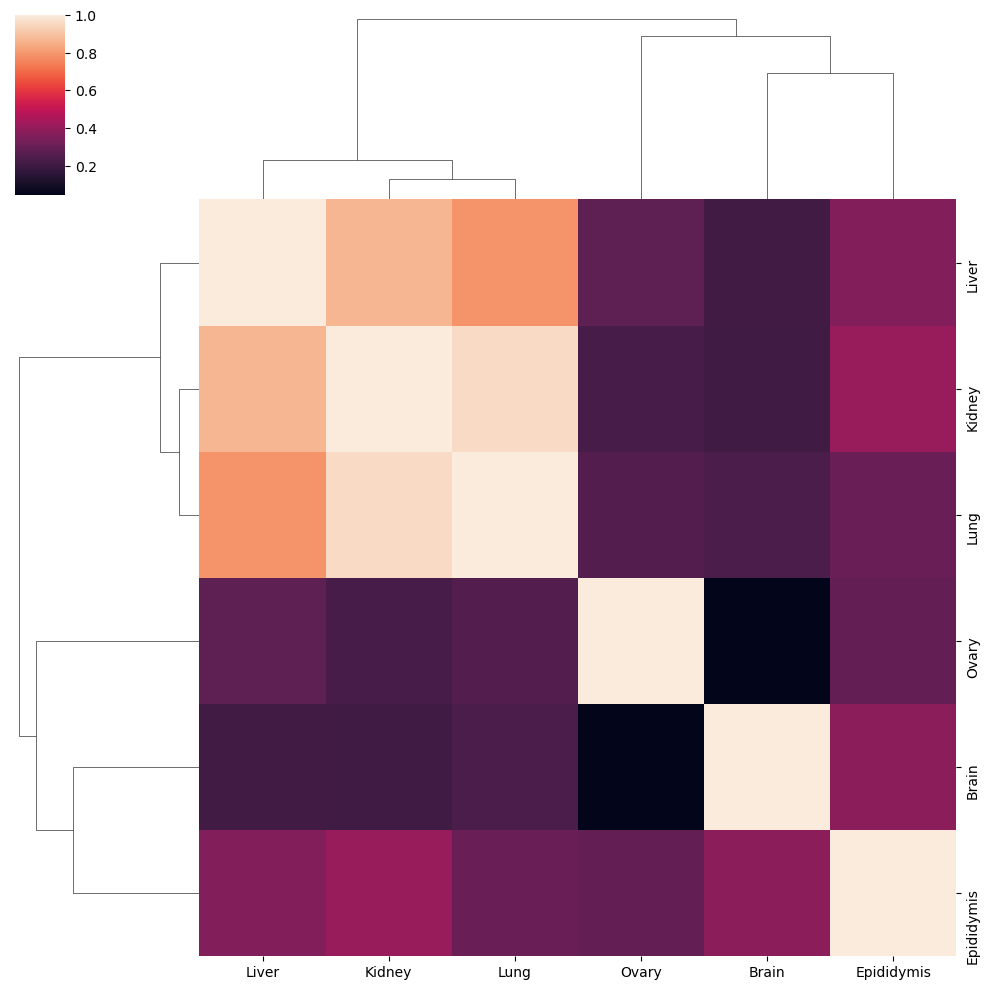

In [90]:
sns.clustermap(pairdf.corr())

In [91]:
df

mean  variance        cv  coocurrence  \
ion_pairs                                                                
(C24H50NO7P, C25H45NO4)      0.706819  0.008700  0.131963     0.346154   
(C24H50NO7P, C37H66O4)       0.733673  0.048443  0.299993     0.453846   
(C24H50NO7P, C37H68O4)       0.752992  0.044193  0.279182     0.530769   
(C24H50NO7P, C37H70O12S)     0.871723  0.009331  0.110810     0.230769   
(C24H50NO7P, C37H71O8P)      0.836817  0.008518  0.110289     0.507692   
...                               ...       ...       ...          ...   
(C51H99O8P, C57H108O6)       0.943637  0.001498  0.041011     0.222222   
(C51H99O8P, C57H98O6)        0.814683  0.008676  0.114332     0.222222   
(C21H27N7O14P2, C48H88NO8P)  0.444676  0.146834  0.861725     0.222222   
(C37H68O4, C48H88NO8P)       0.495099  0.170065  0.832943     0.222222   
(C45H78NO10P, C48H88NO8P)    0.446603  0.169952  0.923084     0.222222   

                                               ion_pairs    median       iqr  \
ion_pairs                                                                      
(C24H50NO7P, C25H45NO4)          (C24H50NO7P, C25H45NO4)  0.740430  0.096563   
(C24H50NO7P, C37H66O4)            (C24H50NO7P, C37H66O4)  0.827780  0.250357   
(C24H50NO7P, C37H68O4)            (C24H50NO7P, C37H68O4)  0.839321  0.263390   
(C24H50NO7P, C37H70O12S)        (C24H50NO7P, C37H70O12S)  0.895521  0.033955   
(C24H50NO7P, C37H71O8P)          (C24H50NO7P, C37H71O8P)  0.856269  0.075276   
...                                                  ...       ...       ...   
(C51H99O8P, C57H108O6)            (C51H99O8P, C57H108O6)  0.943637  0.038700   
(C51H99O8P, C57H98O6)              (C51H99O8P, C57H98O6)  0.814683  0.093144   
(C21H27N7O14P2, C48H88NO8P)  (C21H27N7O14P2, C48H88NO8P)  0.444676  0.383189   
(C37H68O4, C48H88NO8P)            (C37H68O4, C48H88NO8P)  0.495099  0.412390   
(C45H78NO10P, C48H88NO8P)      (C45H78NO10P, C48H88NO8P)  0.446603  0.412252   

                                mediqr  pval_mean  pval_mean_corr  \
ion_pairs                                                           
(C24H50NO7P, C25H45NO4)       7.667810   0.035310       43.466971   
(C24H50NO7P, C37H66O4)        3.306395   0.003799        4.676865   
(C24H50NO7P, C37H68O4)        3.186612   0.000211        0.259144   
(C24H50NO7P, C37H70O12S)     26.373403   0.000029        0.035170   
(C24H50NO7P, C37H71O8P)      11.374983   0.000091        0.111899   
...                                ...        ...             ...   
(C51H99O8P, C57H108O6)       24.383539   0.033699      302.317907   
(C51H99O8P, C57H98O6)         8.746493   0.394176     3536.149292   
(C21H27N7O14P2, C48H88NO8P)   1.160464   0.907511     8141.280745   
(C37H68O4, C48H88NO8P)        1.200562   0.850979     7634.129956   
(C45H78NO10P, C48H88NO8P)     1.083325   0.905793     8125.871721   

                             pval_mediqr  pval_mediqr_corr  tissue  mean_sig  \
ion_pairs                                                                      
(C24H50NO7P, C25H45NO4)         0.000062          0.076933  Kidney     False   
(C24H50NO7P, C37H66O4)          0.000200          0.246151  Kidney     False   
(C24H50NO7P, C37H68O4)          0.000684          0.842219  Kidney     False   
(C24H50NO7P, C37H70O12S)        0.000029          0.035170  Kidney      True   
(C24H50NO7P, C37H71O8P)         0.000091          0.111899  Kidney     False   
...                                  ...               ...     ...       ...   
(C51H99O8P, C57H108O6)          0.239903       2152.165360   Liver     False   
(C51H99O8P, C57H98O6)           0.480769       4312.983166   Liver     False   
(C21H27N7O14P2, C48H88NO8P)     0.952974       8549.129734   Liver     False   
(C37H68O4, C48H88NO8P)          0.944536       8473.429219   Liver     False   
(C45H78NO10P, C48H88NO8P)       0.967912       8683.141984   Liver     False   

                             mediqr_sig  
ion_pairs                                
(C24H5

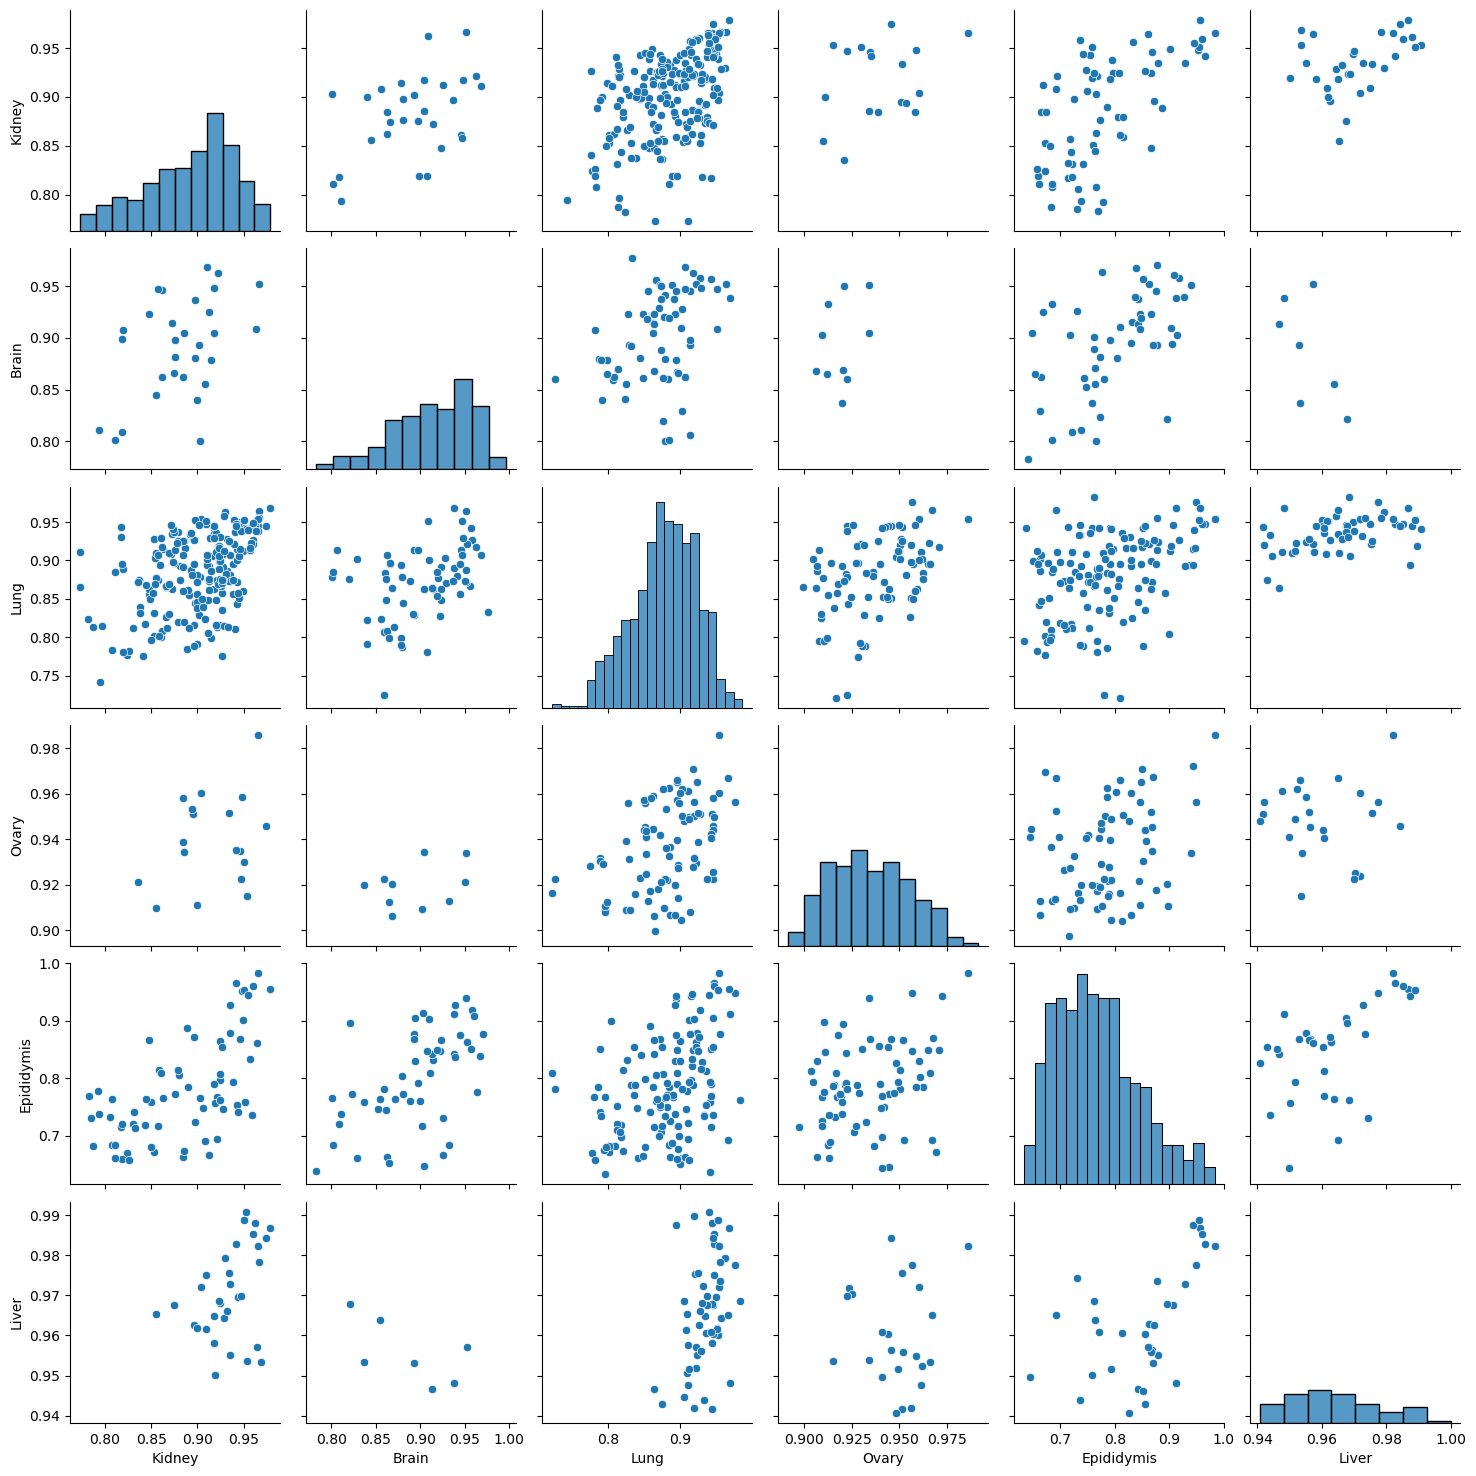

In [93]:
out_dict = {}
for tis in tissue_colocs.keys():
    tmp = df[df['tissue']==tis]
    tmp = tmp[tmp['pval_mean_corr'] <= 0.1]['mean']
    
    curr_series = pd.Series(np.nan, index=list(set(df.index)))
    for key, val in tmp.items():
        curr_series[key]=val
    out_dict[tis] = curr_series
pairdf = pd.DataFrame(out_dict)
    
sns.pairplot(pairdf)

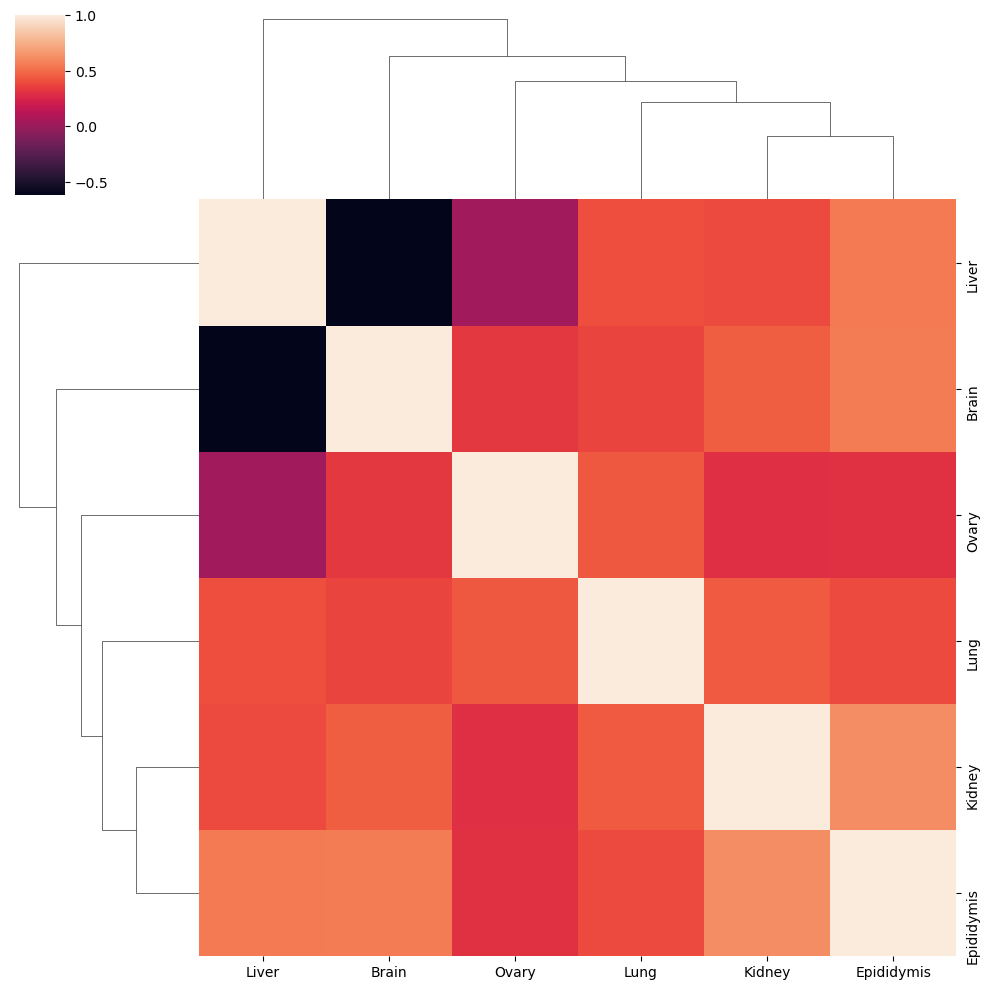

In [94]:
sns.clustermap(pairdf.corr())

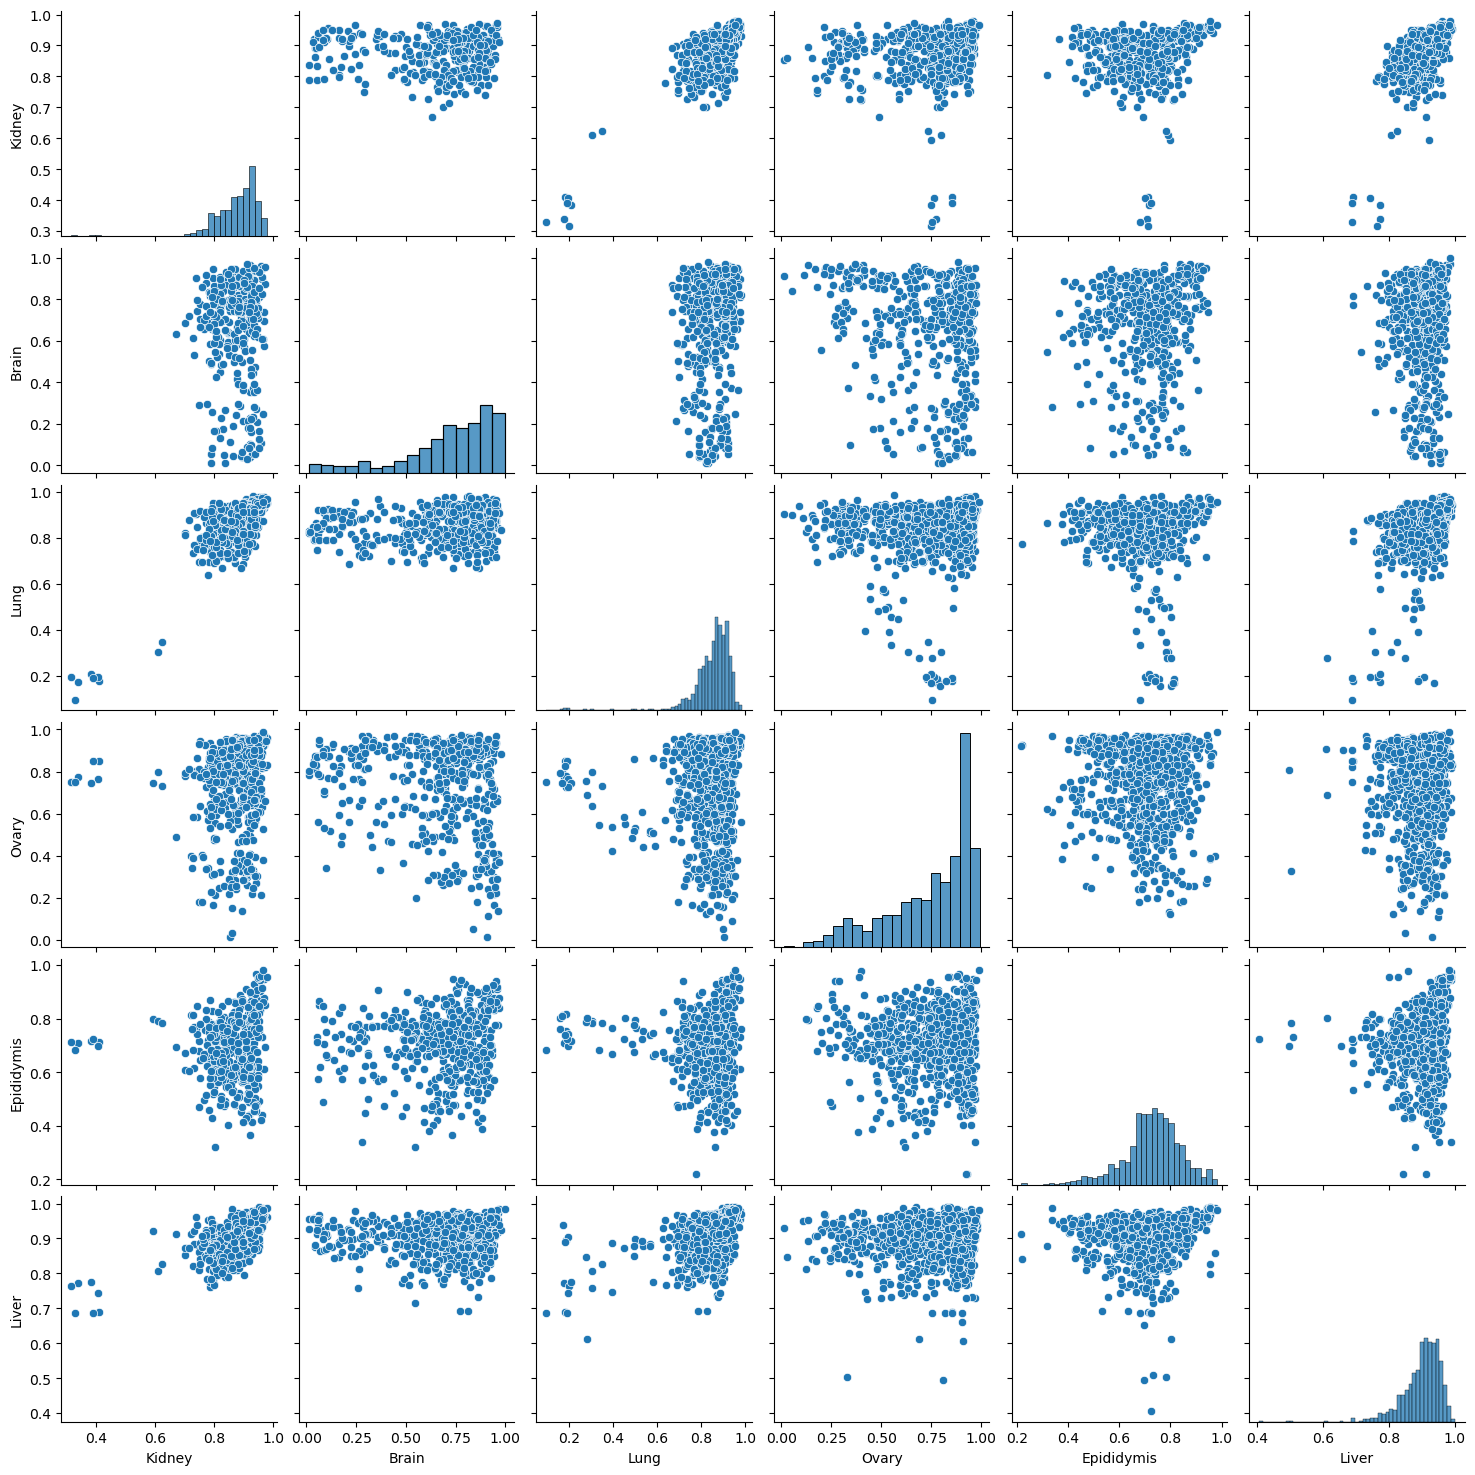

In [97]:
out_dict = {}

sig_corr = df[df['pval_mean_corr'] <= 0.1]

for tis in tissue_colocs.keys():
    tmp = df[df['tissue']==tis]['mean']
    
    curr_series = pd.Series(np.nan, index=list(set(sig_corr.index)))
    for key, val in tmp.items():
        if key in curr_series.index:
            curr_series[key]=val
    out_dict[tis] = curr_series
pairdf = pd.DataFrame(out_dict)
    
sns.pairplot(pairdf)

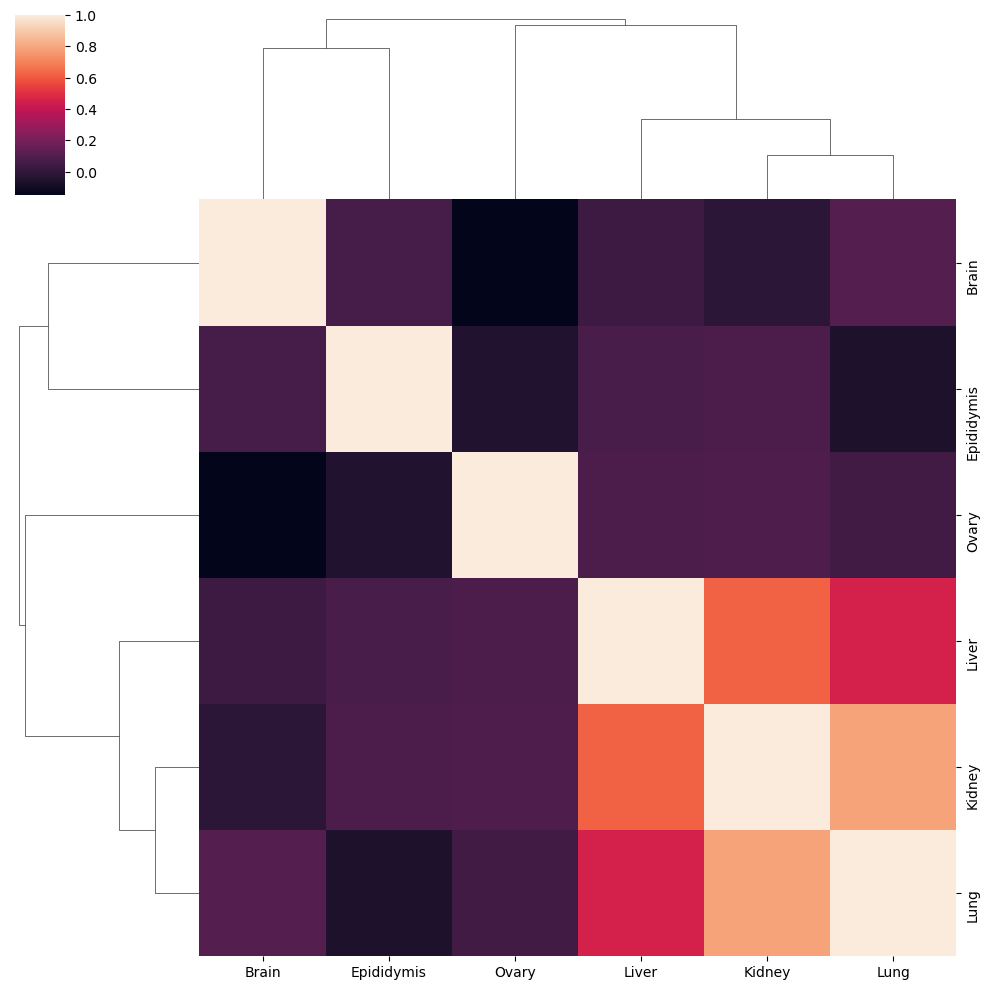

In [98]:
sns.clustermap(pairdf.corr())

### Tissue lipid class colocs

In [99]:
tissue_lx = pickle.load(open(os.path.join(store_dir, 'pos_lip_tissue_lx.pickle'), "rb" ))

In [101]:
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [102]:
max_hops = 1
    
class_list = []
val_list = [] # 
ds_list = [] # 
tissue_list = [] # 
net_edge_list = [] #

# Loop over tissues
for tis in tissue_colocs.keys():
    print(tis)
    # Loop over datasets
    for ds in tissue_colocs[tis]['coloc_dict'].keys():
        
        tmp_colocs = tissue_colocs[tis]['coloc_dict'][ds]
        
        idx = tmp_colocs.index
        
        curr_net = tissue_lx[tis]['nets'][ds]
        
        net_nodes = dict(curr_net.nodes(data=True))
        # Loop over colocs per tissue
        for i in range(len(idx)):
            for j in range(i+1, len(idx)):
                
                if idx[i] in curr_net.nodes and idx[j] in curr_net.nodes:
                    val_list.append(tmp_colocs.loc[idx[i], idx[j]])
                    ds_list.append(ds)
                    tissue_list.append(tis)
                    if catch_sp(curr_net, idx[i], idx[j]) <= max_hops:
                        net_edge_list.append(True)
                    else:
                        net_edge_list.append(False)
                        
                    # Class-class list
                    c1 = lx2.lipid_parser(net_nodes[idx[i]]['sum_species'].index[0], reference_lipids=ref_lip_dict).get_lipid_class()
                    c2 = lx2.lipid_parser(net_nodes[idx[j]]['sum_species'].index[0], reference_lipids=ref_lip_dict).get_lipid_class()

                    #c1 = net_nodes[idx[i]]['sum_species'].index[0].split('(')[0]
                    #c2 = net_nodes[idx[j]]['sum_species'].index[0].split('(')[0]
                    
                    c11, c22 = tuple(sorted([c1, c2]))
                    class_list.append(f'{c11} - {c22}')
                    
                    
cc_df = pd.DataFrame({'cc': class_list, 'coloc': val_list, 'ds': ds_list, 'tissue': tissue_list, 'net_edge': net_edge_list})

Kidney
Brain
Lung
Ovary
Epididymis
Liver


In [108]:
cc_df

cc     coloc                    ds  tissue  net_edge
0         LPC - PA  0.930428  2022-12-07_02h13m50s  Kidney     False
1         LPC - PA  0.939258  2022-12-07_02h13m50s  Kidney     False
2         LPC - PA  0.932311  2022-12-07_02h13m50s  Kidney     False
3         LPC - SM  0.959731  2022-12-07_02h13m50s  Kidney     False
4         LPC - PC  0.966274  2022-12-07_02h13m50s  Kidney      True
...            ...       ...                   ...     ...       ...
481349     TG - TG  0.727207  2017-08-07_13h19m42s   Liver     False
481350  TG - TG O-  0.790074  2017-08-07_13h19m42s   Liver     False
481351     TG - TG  0.705860  2017-08-07_13h19m42s   Liver     False
481352  TG - TG O-  0.836440  2017-08-07_13h19m42s   Liver     False
481353  TG - TG O-  0.541927  2017-08-07_13h19m42s   Liver     False

[481354 rows x 5 columns]

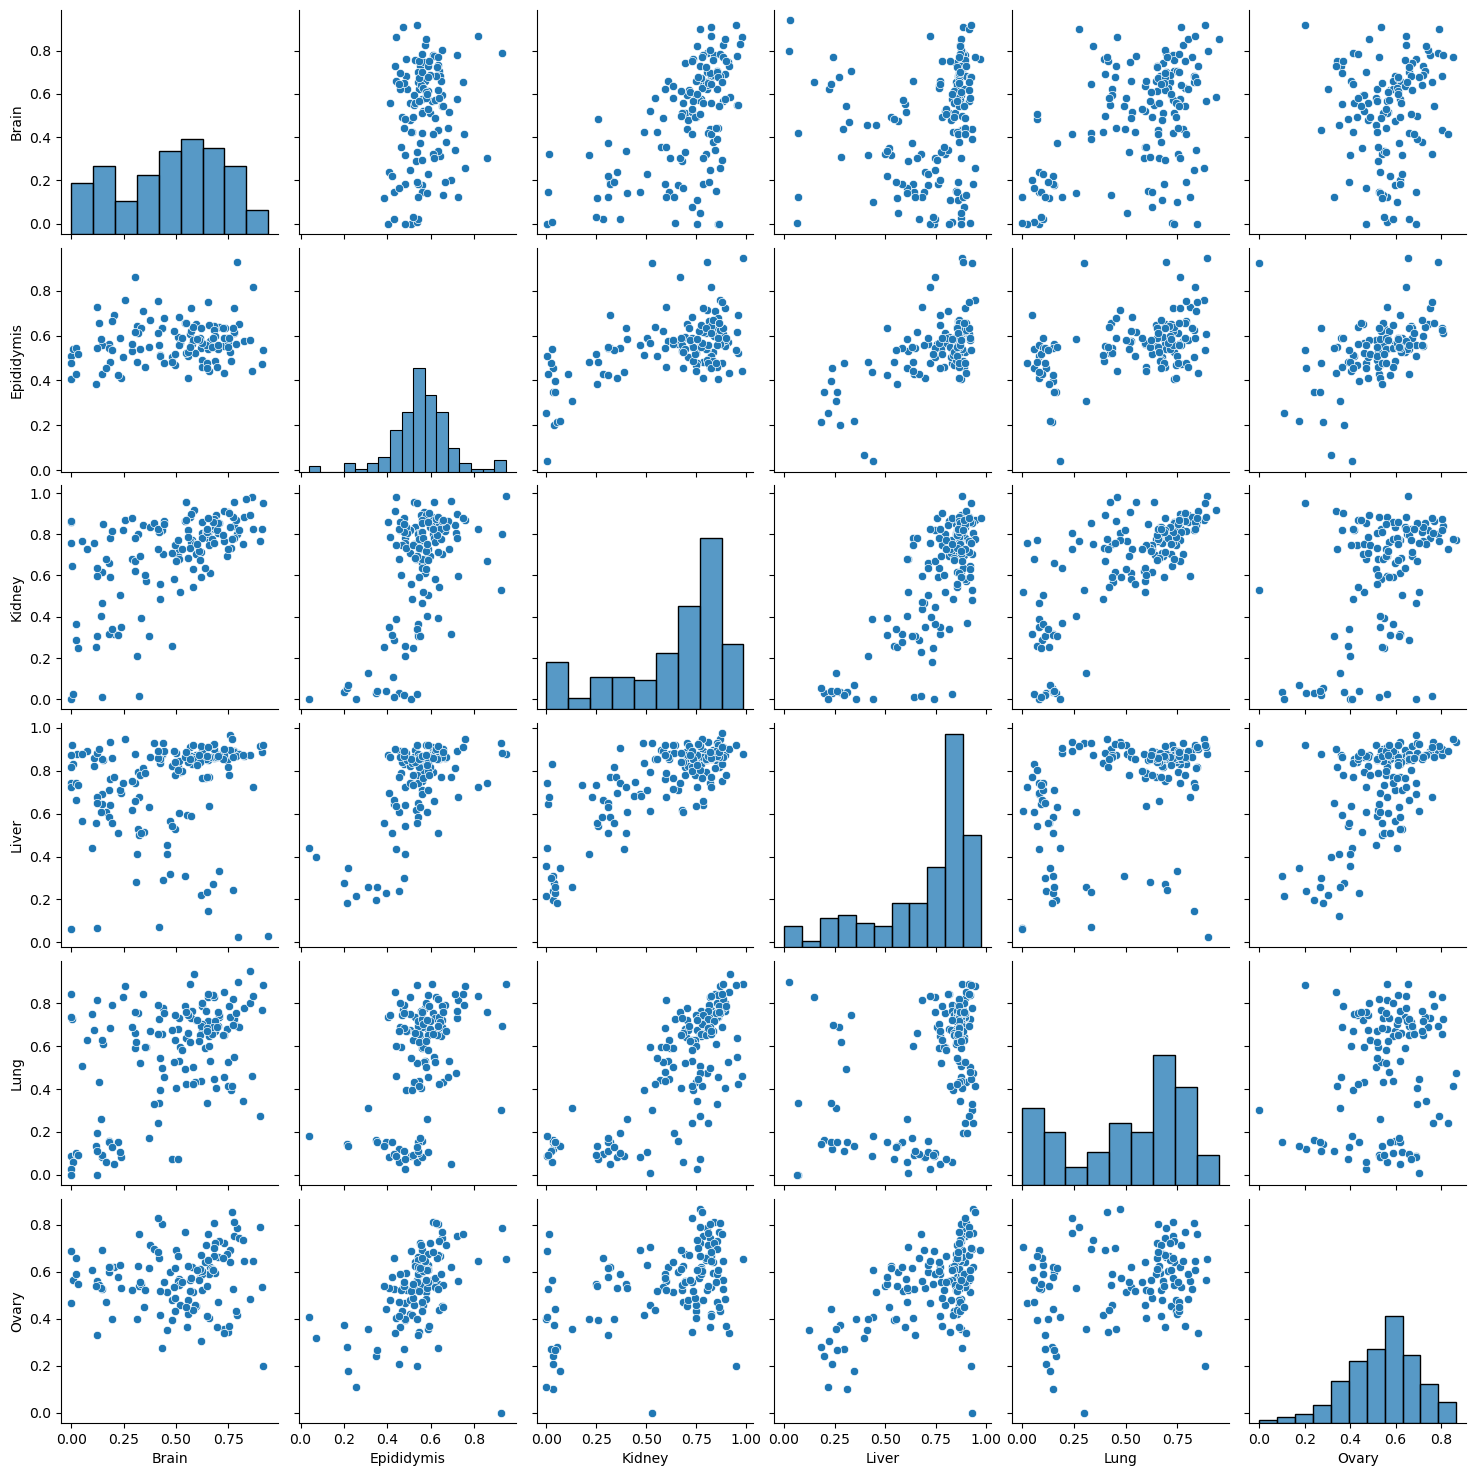

In [146]:
cc_final = cc_df.groupby(['tissue', 'cc']).agg('mean', numeric_only=True).reset_index().drop(columns=['net_edge']).pivot(index='cc',columns='tissue',values='coloc')
sns.pairplot(cc_final)

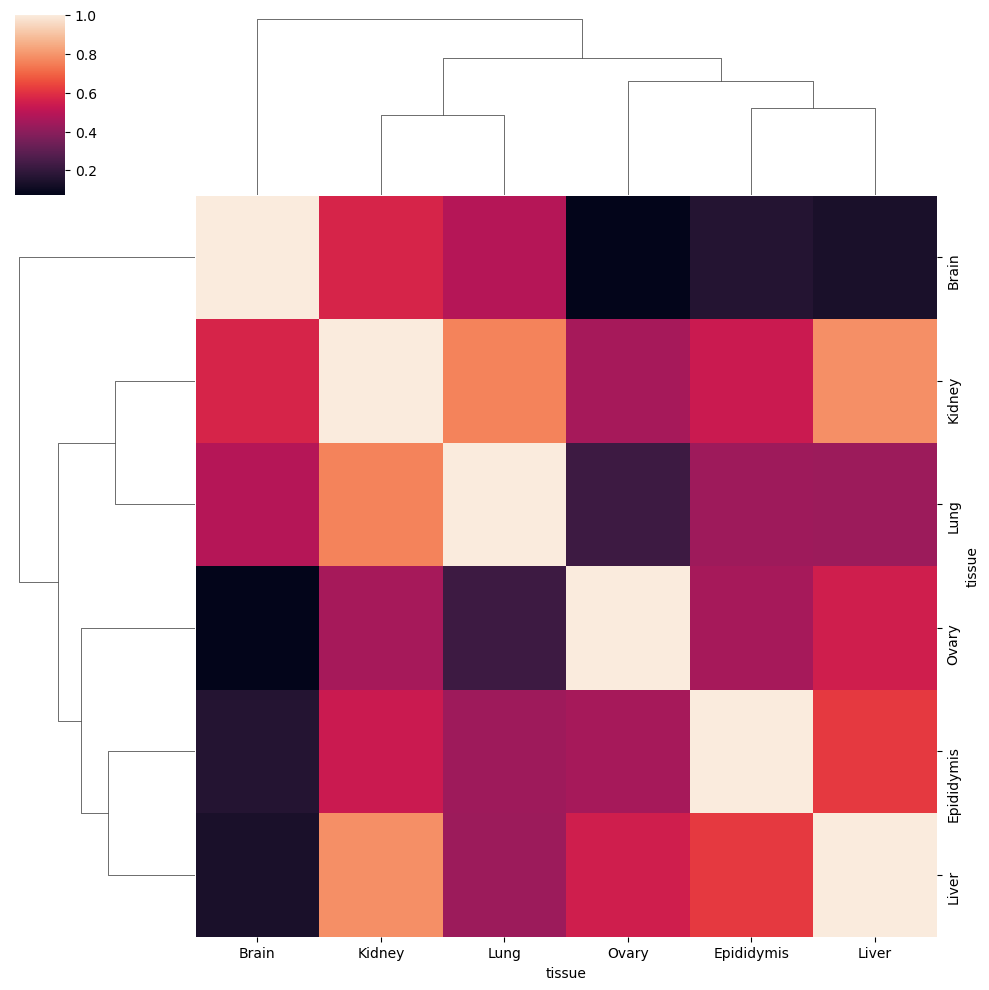

In [147]:
sns.clustermap(cc_final.corr())

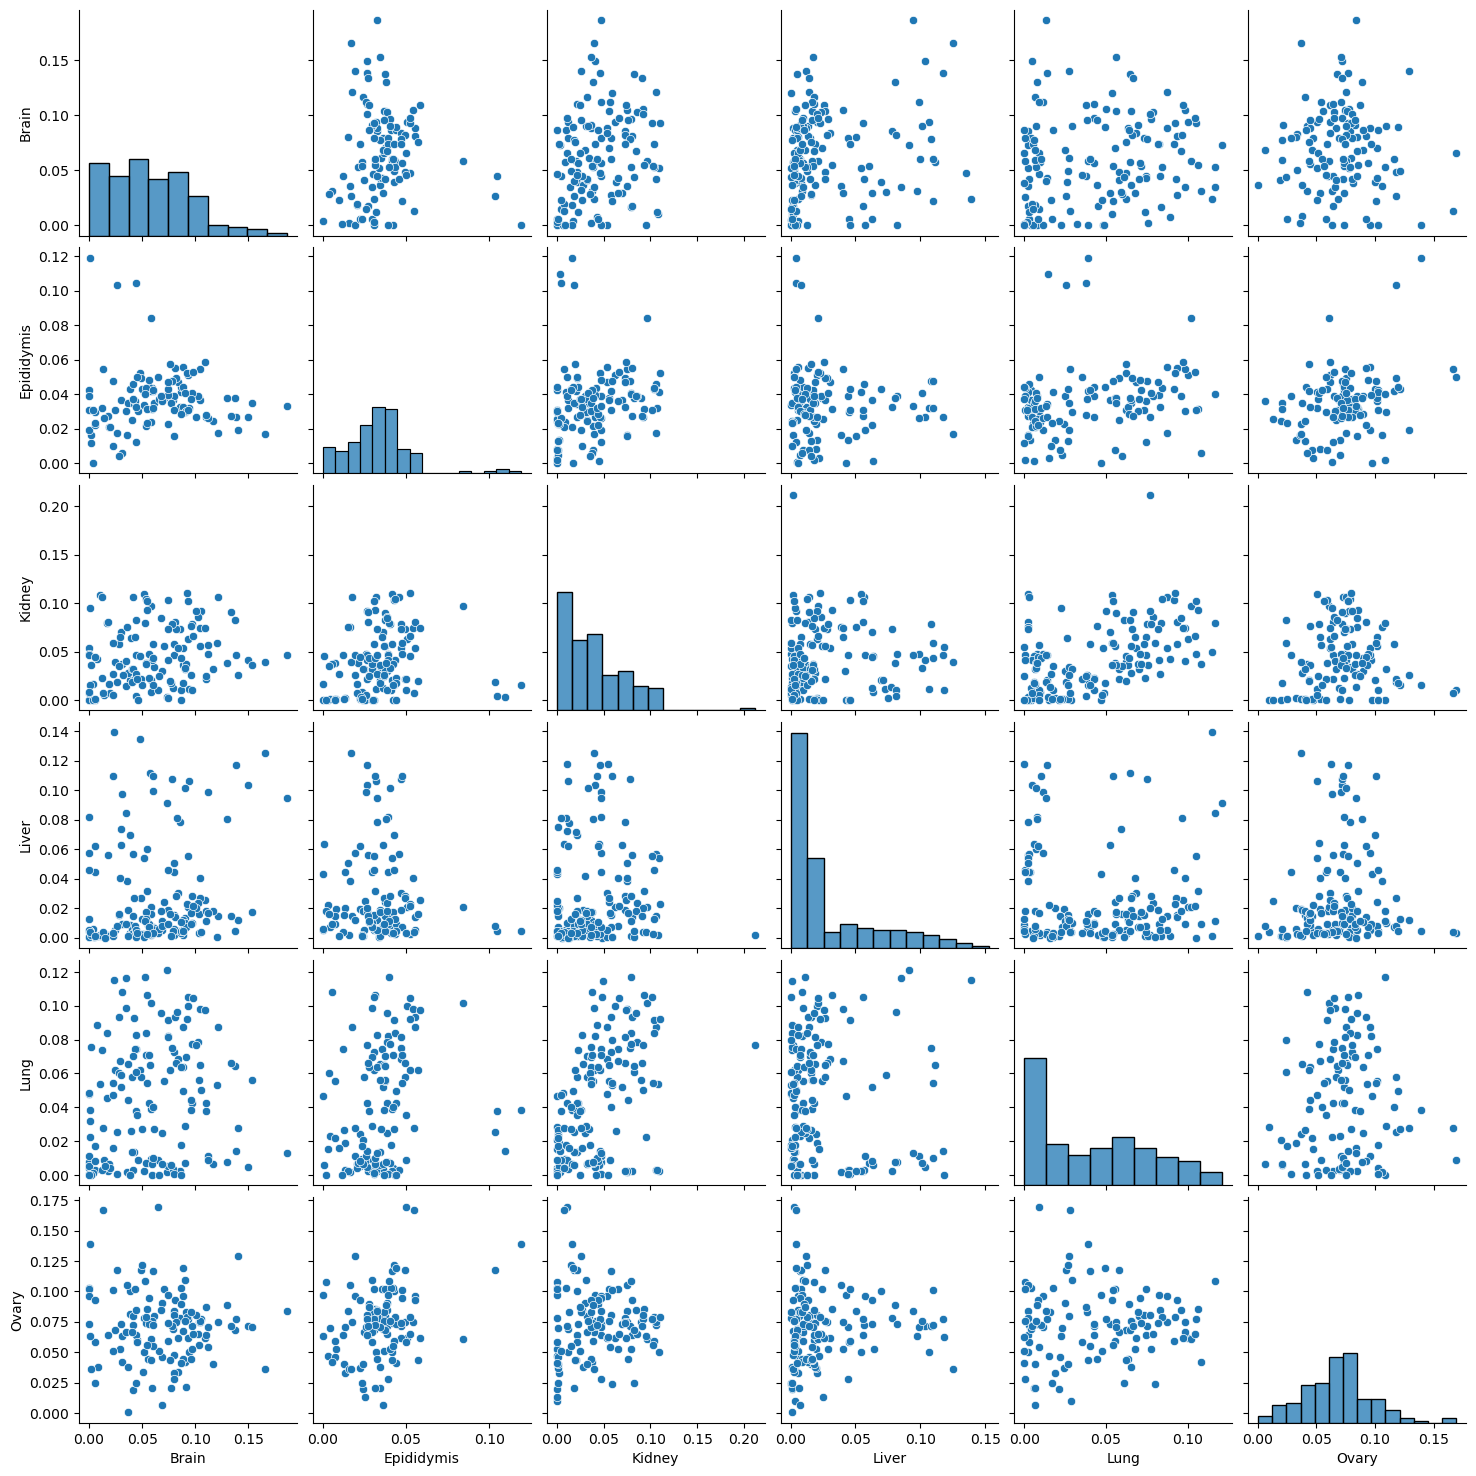

In [148]:
cc_var = cc_df.groupby(['tissue', 'cc']).agg('var', numeric_only=True).reset_index().drop(columns=['net_edge']).pivot(index='cc',columns='tissue',values='coloc')
sns.pairplot(cc_var)

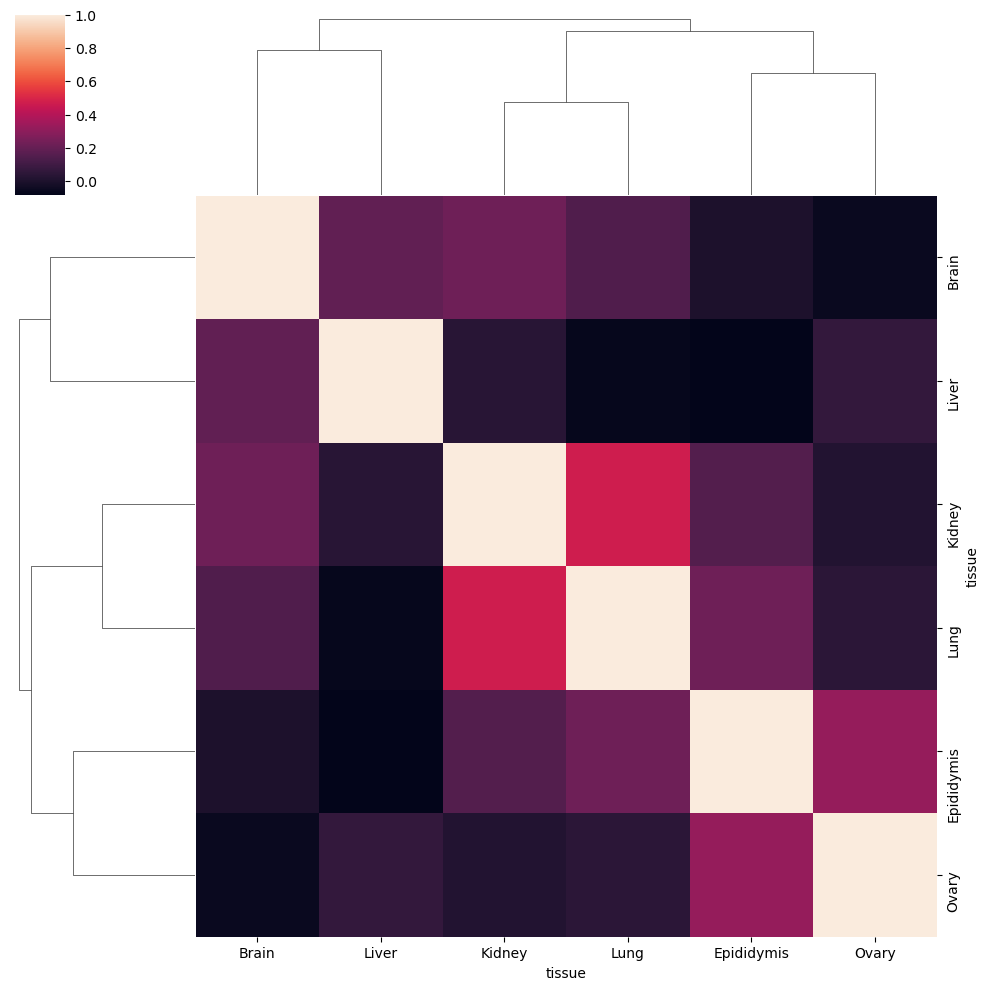

In [149]:
sns.clustermap(cc_var.corr())

In [126]:
cc_tmp = cc_df.groupby(['tissue', 'cc']).agg('mean', numeric_only=True).reset_index().drop(columns=['net_edge'])
cc_2 = cc_tmp.groupby('cc').agg('count')
cc_2[cc_2['tissue'] >= 4].index

Index(['CE - CE', 'CE - DMPE', 'CE - LPC', 'CE - MMPE', 'CE - PA', 'CE - PC',
       'CE - PC O-', 'CE - PE', 'CE - PE O-', 'CE - PG',
       ...
       'PG - TG', 'PI - PS', 'PI - SM', 'PI - TG', 'PS - PS', 'PS - SM',
       'PS - TG', 'SM - SM', 'SM - TG', 'TG - TG'],
      dtype='object', name='cc', length=162)

In [129]:
cc_final

tissue            Brain  Epididymis    Kidney     Liver      Lung     Ovary
cc                                                                         
CE - CE             NaN    0.922937  0.529558  0.929628  0.300838  0.000000
CE - Cer            NaN         NaN       NaN       NaN       NaN  0.365524
CE - CerP           NaN         NaN       NaN  0.382602       NaN       NaN
CE - DG             NaN    0.068933       NaN  0.396580       NaN  0.316631
CE - DMPE           NaN    0.199517  0.035958  0.275569       NaN  0.370897
...                 ...         ...       ...       ...       ...       ...
SM - TG        0.373552    0.548479  0.307523  0.633083  0.172521  0.613992
SM - TG O-          NaN         NaN  0.398265  0.725912       NaN       NaN
TG - TG        0.866219    0.818447  0.823872  0.722429  0.833230  0.644978
TG - TG O-          NaN         NaN  0.818505  0.886678       NaN       NaN
TG O- - TG O-       NaN         NaN  0.877420  0.974087       NaN       NaN

[255 rows x 6 columns]

In [134]:
cc_tmp

tissue          cc     coloc
0     Brain   Cer - Cer  0.759655
1     Brain    Cer - DG  0.472559
2     Brain  Cer - DMPE  0.318369
3     Brain   Cer - LPA  0.049541
4     Brain   Cer - LPC  0.553661
...     ...         ...       ...
1068  Ovary     PS - SM  0.608271
1069  Ovary     PS - TG  0.396434
1070  Ovary     SM - SM  0.761139
1071  Ovary     SM - TG  0.613992
1072  Ovary     TG - TG  0.644978

[1073 rows x 3 columns]

In [139]:
cc_inter = cc_tmp.drop(columns='tissue').groupby('cc').agg(['mean', 'var'], numeric_only=True).dropna().sort_values(by=('coloc', 'var'))

In [143]:
cc_inter.reset_index()[0:20]

cc     coloc          
                       mean       var
0        Cer - PE  0.475237  0.001113
1        PGP - TG  0.021589  0.001234
2     Cer - PE O-  0.558762  0.001373
3        Cer - SM  0.562184  0.001937
4      TG - TG O-  0.852592  0.002324
5        Cer - PG  0.405832  0.002826
6      PI - TG O-  0.674691  0.002974
7        DG - PGP  0.063579  0.003797
8     DMPE - MMPE  0.776641  0.003830
9        Cer - PC  0.545906  0.004122
10       Cer - DG  0.544881  0.004196
11      PGP - PGP  0.901816  0.004306
12  TG O- - TG O-  0.925753  0.004672
13      DMPE - PS  0.638519  0.004826
14      LPE - LPE  0.683799  0.004863
15      MMPE - PS  0.681625  0.005629
16    DMPE - DMPE  0.814326  0.006710
17        TG - TG  0.784863  0.007015
18        CE - PC  0.174012  0.007037
19     Cer - MMPE  0.438238  0.007222

In [144]:
cc_inter.reset_index()[-20:-1]

cc     coloc          
                     mean       var
210     DG - PI  0.444095  0.117530
211   DG - DMPE  0.338341  0.121410
212   DG - MMPE  0.337973  0.122865
213   CerP - PA  0.581582  0.125370
214  DMPE - PGP  0.542441  0.125482
215   CerP - PI  0.459762  0.131360
216   Cer - LPA  0.306624  0.132183
217   CerP - PE  0.550881  0.134800
218   CerP - TG  0.488989  0.137500
219  DMPE - LPA  0.573847  0.138271
220    LPE - PI  0.578801  0.140977
221  PG - TG O-  0.456790  0.152995
222   CerP - PG  0.572996  0.156563
223     CE - CE  0.536592  0.161825
224  LPA - MMPE  0.631303  0.177468
225  CerP - LPA  0.424091  0.210994
226    PG - PGP  0.572595  0.227545
227  CerP - LPE  0.464910  0.254365
228   CerP - DG  0.451522  0.362503

(array([147.,  50.,  18.,   9.,   1.,   2.,   1.,   0.,   1.,   1.]),
 array([0.00111297, 0.04262566, 0.08413836, 0.12565105, 0.16716374,
        0.20867644, 0.25018913, 0.29170182, 0.33321452, 0.37472722,
        0.41623992]),
 <BarContainer object of 10 artists>)

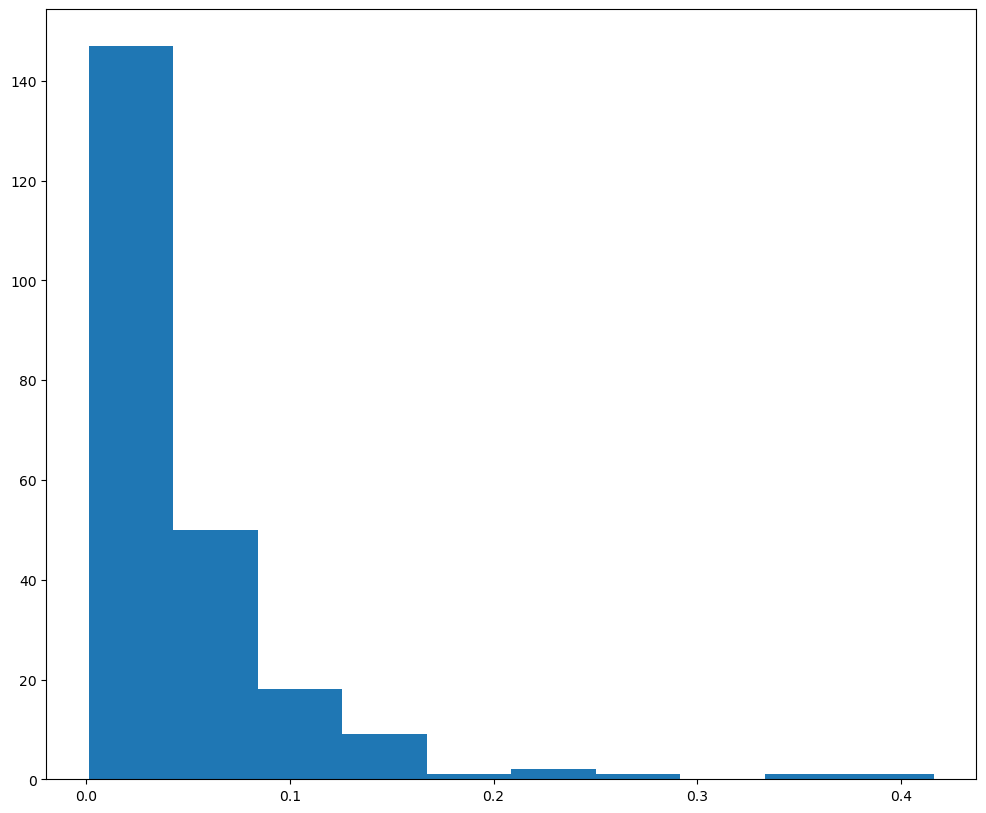

In [140]:
plt.hist(cc_inter[('coloc', 'var')])